# import

In [101]:

# My custom modules:
import acquire as a
import prepare as p

# tabular manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ML stuff:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Acquire


In [2]:
#Using acquire import to fetch raw data
telco_df = a.get_telco_data() 

this file exists, reading csv


## How/Where/When

- data was extracted from sequel database using the following from my imported acquire module
>def get_telco_data()
  -extracts data as a dataframe from server with the users env file and a sql query
  
  -also caches data as a file on users system as a csv for later access

## Observations

In [3]:
#first glance inspection
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


### the columns

-  customer_id:  unique identifier for customers, possible index
- gender, senior_citizen, partner, dependents:  binary customer demographics
- tenure:  time spent on plan in months
- phone_service, tech_support, streaming_tv, streaming_movies:  monthly add-ons (has dupes)
- paperless_billing:  
- monthly_charges:  cost of service including add-ons per month
- total_charges:  charges accumulated across tenure
- churn:  whether the customer terminated service
- contract_type:  service commitment
- internet_service_type:  how service was provided
- payment_type:  how service was paid for

In [4]:
#total_charges is roughly equal to tenure multiplied by monthly charges
telco_df['totalss'] = telco_df.tenure * telco_df.monthly_charges
telco_df[['totalss', 'total_charges']]

,totalss,total_charges
0,590.40,593.3
1,539.10,542.4
2,295.60,280.85
3,1274.00,1237.85
4,251.70,267.4
...,...,...
7038,716.95,742.9
7039,1872.20,1873.7
7040,100.60,92.75
7041,4545.95,4627.65


In [5]:
#removing calculation column
telco_df = telco_df.drop(columns = ['totalss'])

### the data

In [6]:
#Investigating the raw data; noticing nulls in internet_service_type
telco_df.info() 
#7043 rows for 7043 customers 
#24 columns worth of data for each customer
#numeric and non-numeric data available

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_support 

In [7]:
#distinguishing whether numeric cols are categorical 
telco_df.select_dtypes(include = 'number') 
#tenure and monthly_charges are continous, the rest are categorical

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
0,2,1,2,0,9,65.60
1,2,1,1,0,9,59.90
2,1,2,1,0,4,73.90
3,1,2,1,1,13,98.00
4,2,2,1,1,3,83.90
...,...,...,...,...,...,...
7038,2,1,2,0,13,55.15
7039,1,2,1,0,22,85.10
7040,2,1,1,0,2,50.30
7041,2,1,3,0,67,67.85


In [8]:
#distinguishing whether non-numeric cols are categorical
telco_df.select_dtypes(exclude = 'number') 
#all non-numerics are categorical except total_charges and customer_id

,customer_id,gender,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,total_charges,churn,contract_type,internet_service_type,payment_type
0,0002-ORFBO,Female,Yes,Yes,Yes,No,No,Yes,No,Yes,Yes,No,Yes,593.3,No,One year,DSL,Mailed check
1,0003-MKNFE,Male,No,No,Yes,Yes,No,No,No,No,No,Yes,No,542.4,No,Month-to-month,DSL,Mailed check
2,0004-TLHLJ,Male,No,No,Yes,No,No,No,Yes,No,No,No,Yes,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,0011-IGKFF,Male,Yes,No,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,0013-EXCHZ,Female,Yes,No,Yes,No,No,No,No,Yes,Yes,No,Yes,267.4,Yes,Month-to-month,Fiber optic,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,No,No,Yes,No,Yes,No,No,Yes,No,No,No,742.9,No,One year,DSL,Mailed check
7039,9992-RRAMN,Male,Yes,No,Yes,Yes,No,No,No,No,No,Yes,Yes,1873.7,Yes,Month-to-month,Fiber optic,Electronic check
7040,9992-UJOEL,Male,No,No,Yes,No,No,Yes,No,No,No,No,Yes,92.75,No,Month-to-month,DSL,Mailed check
7041,9993-LHIEB,Male,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,No,4627.65,No,Two year,DSL,Mailed check


# Prepare

In [9]:
#importing prepare module.  Cleans data with function: 'prep_telco()'
import prepare as p 

#prep_telco makes following changes
    ###CHANGE### removing redundant cols
    ###CHANGE### filling blank spaces of internet_service_type with 0.0
    ###CHANGE### filling in 'None' for null values

In [63]:
raw = a.get_telco_data()
raw

this file exists, reading csv


,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.60,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.90,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.90,267.4,Yes,Month-to-month,Fiber optic,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2,1,2,9987-LUTYD,Female,0,No,No,13,Yes,...,Yes,No,No,No,55.15,742.9,No,One year,DSL,Mailed check
7039,1,2,1,9992-RRAMN,Male,0,Yes,No,22,Yes,...,No,No,Yes,Yes,85.10,1873.7,Yes,Month-to-month,Fiber optic,Electronic check
7040,2,1,1,9992-UJOEL,Male,0,No,No,2,Yes,...,No,No,No,Yes,50.30,92.75,No,Month-to-month,DSL,Mailed check
7041,2,1,3,9993-LHIEB,Male,0,Yes,Yes,67,Yes,...,Yes,No,Yes,No,67.85,4627.65,No,Two year,DSL,Mailed check


In [26]:
p.prep_telco(raw).isnull().any()

customer_id              False
gender                   False
senior_citizen           False
partner                  False
dependents               False
tenure                   False
phone_service            False
multiple_lines           False
online_security          False
online_backup            False
device_protection        False
tech_support             False
streaming_tv             False
streaming_movies         False
paperless_billing        False
monthly_charges          False
total_charges            False
churn                    False
contract_type            False
internet_service_type    False
payment_type             False
dtype: bool

In [35]:
(p.prep_telco(raw) == ' ').any() 

customer_id              False
gender                   False
senior_citizen           False
partner                  False
dependents               False
tenure                   False
phone_service            False
multiple_lines           False
online_security          False
online_backup            False
device_protection        False
tech_support             False
streaming_tv             False
streaming_movies         False
paperless_billing        False
monthly_charges          False
total_charges            False
churn                    False
contract_type            False
internet_service_type    False
payment_type             False
dtype: bool

In [38]:
(p.prep_telco(raw)).columns.sort_values()

Index(['churn', 'contract_type', 'customer_id', 'dependents',
       'device_protection', 'gender', 'internet_service_type',
       'monthly_charges', 'multiple_lines', 'online_backup', 'online_security',
       'paperless_billing', 'partner', 'payment_type', 'phone_service',
       'senior_citizen', 'streaming_movies', 'streaming_tv', 'tech_support',
       'tenure', 'total_charges'],
      dtype='object')

In [67]:
telco_p = p.prep_telco(raw)
telco_p.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


## encoding

In [83]:
for column in telco_df.columns:
    nuniques = telco_df[column].nunique()
    value_counts = telco_df[column].value_counts()
        
    print(f"\nValue Counts for {column}:\n{value_counts}")


Value Counts for customer_id:
customer_id
0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: count, Length: 7043, dtype: int64

Value Counts for gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64

Value Counts for senior_citizen:
senior_citizen
0    5901
1    1142
Name: count, dtype: int64

Value Counts for partner:
partner
No     3641
Yes    3402
Name: count, dtype: int64

Value Counts for dependents:
dependents
No     4933
Yes    2110
Name: count, dtype: int64

Value Counts for tenure:
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64

Value Counts for phone_service:
phone_service
Yes    6361
No      682
Name: count, dtype: int64

Value Counts for multiple_lines:
multiple_lines
No                  3390
Yes                 2971
No p

In [75]:
telco_p['gender'][:10]

0    Female
1      Male
2      Male
3      Male
4    Female
5    Female
6    Female
7      Male
8    Female
9    Female
Name: gender, dtype: object

In [78]:
#encoding gender so that 'Male' is 1 and Female is 0 
np.where(telco_p['gender'] == 'Male', 1, 0)[:10]

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0])

In [79]:
# with .assign:
telco_p = telco_p.assign(sex_male = np.where(telco_p['gender'] == 'Male', 1, 0))

In [91]:
telco_p.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,sex_male,has_partner,has_dependents,phone_serv
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,65.6,593.3,No,One year,DSL,Mailed check,0,1,1,1
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,59.9,542.4,No,Month-to-month,DSL,Mailed check,1,0,0,1
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check,1,0,0,1
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check,1,1,0,1
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check,0,1,0,1


In [88]:
#encoding partner to new column 'has_partner' where Yes is 1 and No is 0
telco_p = telco_p.assign(has_partner = np.where(telco_p['partner'] == 'Yes', 1, 0))
pd.crosstab(telco_p.has_partner, telco_p.partner)

partner,No,Yes
has_partner,,
0,3641,0
1,0,3402


In [89]:
#encoding dependents to new column 'has_dependents' where Yes is 1 and No is 0
telco_p = telco_p.assign(has_dependents = np.where(telco_p['dependents'] == 'Yes', 1, 0))
pd.crosstab(telco_p.dependents, telco_p.has_dependents)

has_dependents,0,1
dependents,,
No,4933,0
Yes,0,2110


In [90]:
#encoding phone_service to new column 'phone_serv' where Yes is 1 and No is 0
telco_p = telco_p.assign(phone_serv = np.where(telco_p['phone_service'] == 'Yes', 1, 0))
pd.crosstab(telco_p.phone_service, telco_p.phone_serv)

phone_serv,0,1
phone_service,,
No,682,0
Yes,0,6361


In [92]:
#encoding multiple_lines to new column 'mult_lines' where Yes is 1 and No is 0
telco_p = telco_p.assign(mult_lines = np.where(telco_p['multiple_lines'] == 'Yes', 1, 0))
pd.crosstab(telco_p.mult_lines, telco_p.multiple_lines)

multiple_lines,No,No phone service,Yes
mult_lines,,,
0,3390,682,0
1,0,0,2971


In [93]:
#encoding online_security to new column 'online_sec' where Yes is 1 and No is 0
telco_p = telco_p.assign(online_sec = np.where(telco_p['online_security'] == 'Yes', 1, 0))
pd.crosstab(telco_p.online_sec, telco_p.online_security)

online_security,No,No internet service,Yes
online_sec,,,
0,3498,1526,0
1,0,0,2019


In [94]:
#encoding online_backup to new column 'online_back' where Yes is 1 and No is 0
telco_p = telco_p.assign(online_back = np.where(telco_p['online_backup'] == 'Yes', 1, 0))
pd.crosstab(telco_p.online_back, telco_p.online_backup)

online_backup,No,No internet service,Yes
online_back,,,
0,3088,1526,0
1,0,0,2429


In [95]:
#encoding device_protection to new column 'int_device_prot' where Yes is 1 and No is 0
telco_p = telco_p.assign(int_device_prot = np.where(telco_p['device_protection'] == 'Yes', 1, 0))
pd.crosstab(telco_p.int_device_prot, telco_p.device_protection)

device_protection,No,No internet service,Yes
int_device_prot,,,
0,3095,1526,0
1,0,0,2422


In [96]:
#encoding tech_support to new column 'int_tech_sup' where Yes is 1 and No is 0
telco_p = telco_p.assign(int_tech_sup = np.where(telco_p['tech_support'] == 'Yes', 1, 0))
pd.crosstab(telco_p.int_tech_sup, telco_p.tech_support)

tech_support,No,No internet service,Yes
int_tech_sup,,,
0,3473,1526,0
1,0,0,2044


In [97]:
#encoding streaming_tv to new column 'int_tv_stream' where Yes is 1 and No is 0
telco_p = telco_p.assign(int_tv_stream = np.where(telco_p['streaming_tv'] == 'Yes', 1, 0))
pd.crosstab(telco_p.int_tv_stream, telco_p.streaming_tv)

streaming_tv,No,No internet service,Yes
int_tv_stream,,,
0,2810,1526,0
1,0,0,2707


In [98]:
#encoding streaming_movies to new column 'int_movie_stream' where Yes is 1 and No is 0
telco_p = telco_p.assign(int_movie_stream = np.where(telco_p['streaming_movies'] == 'Yes', 1, 0))
pd.crosstab(telco_p.int_movie_stream, telco_p.streaming_movies)

streaming_movies,No,No internet service,Yes
int_movie_stream,,,
0,2785,1526,0
1,0,0,2732


In [99]:
#encoding paperless_billing to new column 'paperless_bills' where Yes is 1 and No is 0
telco_p = telco_p.assign(paperless_bills = np.where(telco_p['paperless_billing'] == 'Yes', 1, 0))
pd.crosstab(telco_p.paperless_bills, telco_p.paperless_billing)

paperless_billing,No,Yes
paperless_bills,,
0,2872,0
1,0,4171


In [100]:
#encoding churn to new column 'churned' where Yes is 1 and No is 0
telco_p = telco_p.assign(churned = np.where(telco_p['churn'] == 'Yes', 1, 0))
pd.crosstab(telco_p.churn, telco_p.churned)

churned,0,1
churn,,
No,5174,0
Yes,0,1869


In [112]:
#encoding contract_type to new columns 'one_year_contract', 'two_year_contract' where Yes is 1 and No is 0
telco_p[['one_year_contract', 'two_year_contract']] = pd.get_dummies(telco_p.contract_type, drop_first=True).astype(int)
pd.crosstab(telco_p.two_year_contract, telco_p.contract_type)

contract_type,Month-to-month,One year,Two year
two_year_contract,,,
0,3875,1473,0
1,0,0,1695


In [113]:
#encoding internet_service_type to new column has_internet where None is 0 and otherwise 1
telco_p = telco_p.assign(has_internet = np.where(telco_p['internet_service_type'] == 'None', 0, 1))
pd.crosstab(telco_p.has_internet, telco_p.internet_service_type)

internet_service_type,DSL,Fiber optic,None
has_internet,,,
0,0,0,1526
1,2421,3096,0


In [114]:
#encoding internet_service_type to new column has_fiber where Fiber is 1 and otherwise 0
telco_p = telco_p.assign(has_fiber = np.where(telco_p['internet_service_type'] == 'Fiber optic', 1, 0))
pd.crosstab(telco_p.has_fiber, telco_p.internet_service_type)

internet_service_type,DSL,Fiber optic,None
has_fiber,,,
0,2421,0,1526
1,0,3096,0


In [119]:
#encoding payment_type to new column has_DSL where Fiber is 1 and otherwise 0
telco_p = telco_p.assign(auto_bank_payment = np.where(telco_p['payment_type'] == 'Bank transfer (automatic)', 1, 0))
telco_p = telco_p.assign(auto_credit_payment = np.where(telco_p['payment_type'] == 'Credit card (automatic)', 1, 0))
telco_p = telco_p.assign(elec_check_payment = np.where(telco_p['payment_type'] == 'Electronic check', 1, 0))
telco_p = telco_p.assign(mail_check_payment = np.where(telco_p['payment_type'] == 'Mailed check', 1, 0))

pd.crosstab(telco_p.elec_check_payment, telco_p.payment_type)

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
elec_check_payment,,,,
0,1544,1522,0,1612
1,0,0,2365,0


In [132]:
columns=telco_p.select_dtypes('object').columns
df_encoded = telco_p.drop(columns=columns)
df_encoded.dtypes

senior_citizen           int64
tenure                   int64
monthly_charges        float64
sex_male                 int64
has_partner              int64
has_dependents           int64
phone_serv               int64
mult_lines               int64
online_sec               int64
online_back              int64
int_device_prot          int64
int_tech_sup             int64
int_tv_stream            int64
int_movie_stream         int64
paperless_bills          int64
churned                  int64
is_1_year                int64
is_2_year                int64
1_year_contract          int64
2_year_contract          int64
one_year_contract        int64
two_year_contract        int64
has_internet             int64
has_fiber                int64
electronic_check         int64
mailed_check             int64
auto_bank_transfer       int64
auto_credit_card         int64
auto_bank_payment        int64
auto_credit_payment      int64
elec_check_payment       int64
mail_check_payment       int64
dtype: o

In [127]:
telco_p.select_dtypes('object').columns

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type'],
      dtype='object')

## duplicates

In [10]:
#another glance at raw data
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [11]:
# checking for redundant cols
telco_df.columns
#'type_id' columns are unneccesary

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [12]:
#confirming type ids are redundant
telco_df[['payment_type_id', 'payment_type', 'internet_service_type_id', 'internet_service_type', 'contract_type_id', 'contract_type'   ]]

,payment_type_id,payment_type,internet_service_type_id,internet_service_type,contract_type_id,contract_type
0,2,Mailed check,1,DSL,2,One year
1,2,Mailed check,1,DSL,1,Month-to-month
2,1,Electronic check,2,Fiber optic,1,Month-to-month
3,1,Electronic check,2,Fiber optic,1,Month-to-month
4,2,Mailed check,2,Fiber optic,1,Month-to-month
...,...,...,...,...,...,...
7038,2,Mailed check,1,DSL,2,One year
7039,1,Electronic check,2,Fiber optic,1,Month-to-month
7040,2,Mailed check,1,DSL,1,Month-to-month
7041,2,Mailed check,1,DSL,3,Two year


In [13]:
###CHANGE### removing redundant cols
telco_df = telco_df.drop(columns = ['payment_type_id','internet_service_type_id','contract_type_id'])

In [14]:
#checking for duplicate rows based on customer id as index
telco_df.customer_id.duplicated().any()

False

In [15]:
#confirming no duplicate rows
telco_df.customer_id.duplicated().sum()

0

## Nulls

### blanks

In [16]:
#Investigating the raw data, noticed top val for total_charges is blank
telco_df.describe(include='all') 

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043.000000,7043,7043,7043,5517,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,2,NaN,6531,2,3,2,4
top,0002-ORFBO,Male,NaN,No,No,NaN,Yes,No,No,No,...,No,No,No,Yes,NaN,,No,Month-to-month,Fiber optic,Electronic check
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3498,3088,...,3473,2810,2785,4171,NaN,11,5174,3875,3096,2365
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,NaN,NaN,NaN


In [17]:
#checking for blanks in data
(telco_df == ' ').any() 

customer_id              False
gender                   False
senior_citizen           False
partner                  False
dependents               False
tenure                   False
phone_service            False
multiple_lines           False
online_security          False
online_backup            False
device_protection        False
tech_support             False
streaming_tv             False
streaming_movies         False
paperless_billing        False
monthly_charges          False
total_charges             True
churn                    False
contract_type            False
internet_service_type    False
payment_type             False
dtype: bool

In [18]:
#reviewing rows with blanks
telco_df[telco_df.total_charges == ' ']
#tenure of 0: infer customers have not been charged yet

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
945,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,...,Yes,Yes,No,No,56.05,,No,Two year,DSL,Credit card (automatic)
1731,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,20.00,,No,Two year,NaN,Mailed check
1906,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,...,Yes,No,No,Yes,61.90,,No,Two year,DSL,Bank transfer (automatic)
2025,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,19.70,,No,One year,NaN,Mailed check
2176,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,20.25,,No,Two year,NaN,Mailed check
2250,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,25.35,,No,Two year,NaN,Mailed check
2855,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,...,Yes,Yes,No,No,73.35,,No,Two year,DSL,Mailed check
3052,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,25.75,,No,Two year,NaN,Mailed check
3118,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,Yes,No,...,Yes,Yes,No,Yes,52.55,,No,Two year,DSL,Bank transfer (automatic)
4054,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,...,No,Yes,Yes,No,80.85,,No,Two year,DSL,Mailed check


In [19]:
###CHANGE### filling blank spaces with zero
telco_df.total_charges = telco_df.total_charges.str.replace(' ', '0.0')
#checking for blanks in data
(telco_df == ' ').any() 

customer_id              False
gender                   False
senior_citizen           False
partner                  False
dependents               False
tenure                   False
phone_service            False
multiple_lines           False
online_security          False
online_backup            False
device_protection        False
tech_support             False
streaming_tv             False
streaming_movies         False
paperless_billing        False
monthly_charges          False
total_charges            False
churn                    False
contract_type            False
internet_service_type    False
payment_type             False
dtype: bool

### null

In [20]:
#checking for null values
telco_df.isnull().sum()
#internet_service_type has nulls

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type    1526
payment_type                0
dtype: int64

In [21]:
#checking data for rows with nulls
telco_df[telco_df.internet_service_type.isnull() == True]

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
20,0023-UYUPN,Female,1,Yes,No,50,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,25.20,1306.3,No,One year,NaN,Electronic check
23,0030-FNXPP,Female,0,No,No,3,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.85,57.2,No,Month-to-month,NaN,Mailed check
24,0031-PVLZI,Female,0,Yes,Yes,4,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,Month-to-month,NaN,Mailed check
27,0040-HALCW,Male,0,Yes,Yes,54,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,20.40,1090.6,No,Two year,NaN,Credit card (automatic)
28,0042-JVWOJ,Male,0,No,No,26,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,19.60,471.85,No,One year,NaN,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,9970-QBCDA,Female,0,No,No,6,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.70,129.55,No,Month-to-month,NaN,Credit card (automatic)
7028,9972-EWRJS,Female,0,Yes,Yes,67,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,19.25,1372.9,No,Two year,NaN,Bank transfer (automatic)
7032,9975-GPKZU,Male,0,Yes,Yes,46,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.75,856.5,No,Two year,NaN,Credit card (automatic)
7033,9975-SKRNR,Male,0,No,No,1,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,18.90,18.9,No,Month-to-month,NaN,Mailed check


In [22]:
#make mask for rows with null values
mask = telco_df[telco_df.internet_service_type.isnull() == True]
mask.online_security.value_counts()
#confirm null customers have no internet service

online_security
No internet service    1526
Name: count, dtype: int64

In [23]:
###CHANGE### filling in 'None' for null values
telco_df.internet_service_type = telco_df.internet_service_type.fillna('None')
telco_df.internet_service_type.value_counts()

internet_service_type
Fiber optic    3096
DSL            2421
None           1526
Name: count, dtype: int64

In [24]:
#confirming no nulls in data
telco_df.isnull().any()

customer_id              False
gender                   False
senior_citizen           False
partner                  False
dependents               False
tenure                   False
phone_service            False
multiple_lines           False
online_security          False
online_backup            False
device_protection        False
tech_support             False
streaming_tv             False
streaming_movies         False
paperless_billing        False
monthly_charges          False
total_charges            False
churn                    False
contract_type            False
internet_service_type    False
payment_type             False
dtype: bool

## Outliers
no outliers found worth noting

### continous

In [27]:
#another glance
telco_df.head()
#monthly_charge, total_charge, and tenure are continous

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [28]:
#confirming our continous variables
telco_df.nunique().sort_values()


gender                      2
senior_citizen              2
partner                     2
dependents                  2
phone_service               2
paperless_billing           2
churn                       2
device_protection           3
contract_type               3
multiple_lines              3
online_security             3
online_backup               3
internet_service_type       3
tech_support                3
streaming_tv                3
streaming_movies            3
payment_type                4
tenure                     73
monthly_charges          1585
total_charges            6531
customer_id              7043
dtype: int64

<Axes: >

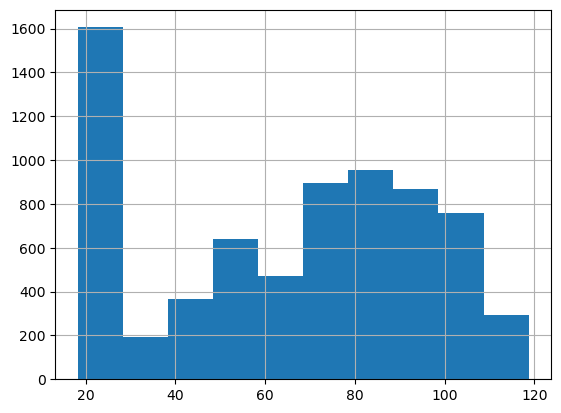

In [29]:
telco_df.monthly_charges.hist()

<Axes: >

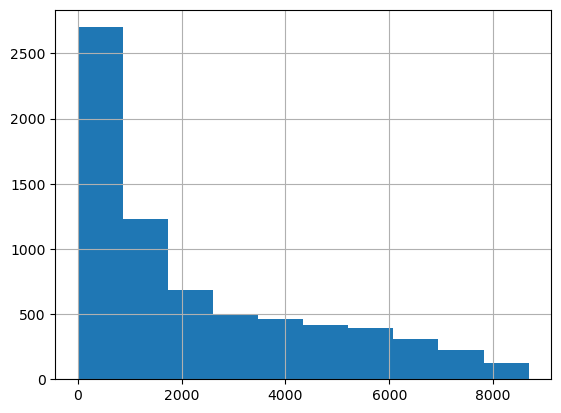

In [30]:
telco_df.total_charges.astype('float').hist()

<Axes: >

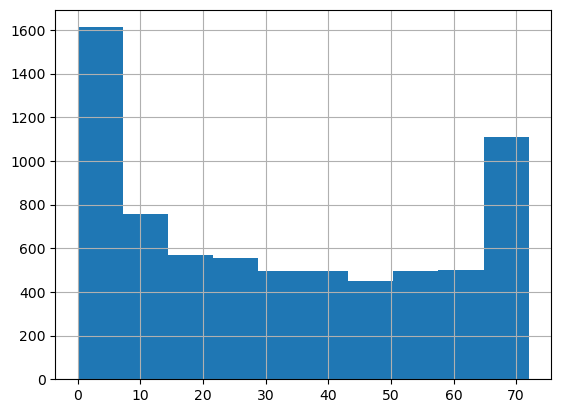

In [31]:
telco_df.tenure.hist()

### categorical

In [32]:
telco_df.nunique()

customer_id              7043
gender                      2
senior_citizen              2
partner                     2
dependents                  2
tenure                     73
phone_service               2
multiple_lines              3
online_security             3
online_backup               3
device_protection           3
tech_support                3
streaming_tv                3
streaming_movies            3
paperless_billing           2
monthly_charges          1585
total_charges            6531
churn                       2
contract_type               3
internet_service_type       3
payment_type                4
dtype: int64

In [33]:
#checking categorical columns for anomalies
for column in telco_df.columns:
    nuniques = telco_df[column].nunique()
    value_counts = telco_df[column].value_counts()
    if nuniques < 10:
        
        print(f"\nValue Counts for {column}:\n{value_counts}")
#no anomalies spotted


Value Counts for gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64

Value Counts for senior_citizen:
senior_citizen
0    5901
1    1142
Name: count, dtype: int64

Value Counts for partner:
partner
No     3641
Yes    3402
Name: count, dtype: int64

Value Counts for dependents:
dependents
No     4933
Yes    2110
Name: count, dtype: int64

Value Counts for phone_service:
phone_service
Yes    6361
No      682
Name: count, dtype: int64

Value Counts for multiple_lines:
multiple_lines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Value Counts for online_security:
online_security
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

Value Counts for online_backup:
online_backup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

Value Counts for device_protection:
device_protection
No                  

# Explore

In [3]:
#extract clean data using prepare module
telco_prepped = p.prep_telco(a.get_telco_data()) #fetching clean data directly from raw data
telco_p = p.encode_telco(telco_prepped)
telco_prepped.head()

this file exists, reading csv


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [4]:
#split data using prepare module function and sklearn function, stratifying on target variable
train, val, test = p.splitting_data(telco_prepped, 'churn')

In [29]:
train.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

## q1 Hypothesis: Do longer contract types correlate to higher churn?

### Visualize

In [6]:
#look at data
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2865,4083-BFNYK,Female,1,Yes,No,38,Yes,Yes,Yes,Yes,...,No,No,Yes,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic)
4107,5804-LEPIM,Female,1,No,No,2,Yes,No,No,No,...,No,No,No,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check
3453,4895-TMWIR,Male,1,Yes,No,11,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.95,214.75,Yes,Month-to-month,None,Mailed check
923,1342-JPNKI,Male,0,No,No,10,Yes,Yes,No,No,...,No,Yes,No,Yes,86.05,834.1,Yes,Month-to-month,Fiber optic,Bank transfer (automatic)
2370,3397-AVTKU,Male,0,No,No,43,Yes,No,No,Yes,...,No,No,Yes,Yes,60.00,2548.55,No,Two year,DSL,Electronic check


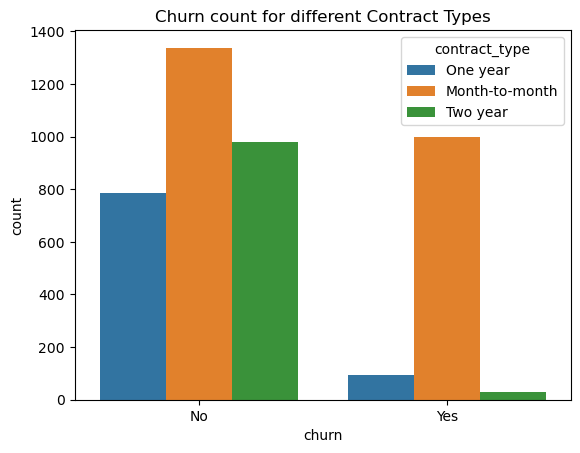

In [45]:
#plotting 
sns.countplot(data = train, x= train.churn, hue= train.contract_type);
plt.title('Churn count for different Contract Types')
plt.show()

### Analyze (with stats)

In [10]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "churn and contract_type are independent"
alternative_hypothesis = "there is a relationship between contract_type and churn"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn, train.contract_type)
chi2, p, dof, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that churn and contract_type are independent
Sufficient evidence to move forward understanding that there is a relationship between contract_type and churn


### Summarize

We can conclude that shorter contracts lead to higher churn.

## q2 Hypothesis: Does monthly charge correlate to churn?

### Visualize

In [14]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2865,4083-BFNYK,Female,1,Yes,No,38,Yes,Yes,Yes,Yes,...,No,No,Yes,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic)
4107,5804-LEPIM,Female,1,No,No,2,Yes,No,No,No,...,No,No,No,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check
3453,4895-TMWIR,Male,1,Yes,No,11,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,19.95,214.75,Yes,Month-to-month,None,Mailed check
923,1342-JPNKI,Male,0,No,No,10,Yes,Yes,No,No,...,No,Yes,No,Yes,86.05,834.1,Yes,Month-to-month,Fiber optic,Bank transfer (automatic)
2370,3397-AVTKU,Male,0,No,No,43,Yes,No,No,Yes,...,No,No,Yes,Yes,60.00,2548.55,No,Two year,DSL,Electronic check


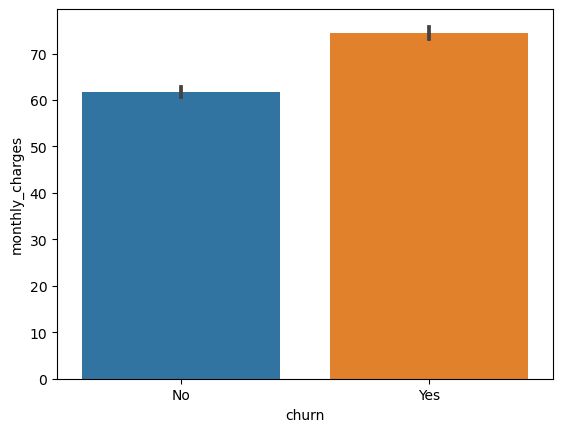

In [41]:
sns.barplot(data = train, x= train.churn, y=train.monthly_charges);

### Analyze (with stats)

In [22]:
#using shapiro test to discern whether data is normally distributed
statistic, p_value = stats.shapiro(train.monthly_charges)
print("Shapiro-Wilk test p-value:", p_value)
#p value is super low, we can assume sample is not normal

Shapiro-Wilk test p-value: 5.647232811229013e-43


In [26]:
train.monthly_charges

2865     95.00
4107     70.35
3453     19.95
923      86.05
2370     60.00
         ...  
1286     70.50
4999     59.60
6892    116.95
3718     86.55
5354     70.15
Name: monthly_charges, Length: 4225, dtype: float64

In [28]:

alpha = 0.05
null_hypothesis = "churn and monthly_charges are independent"
alternative_hypothesis = "there is a relationship between monthly_charges and churn"

stat, p_value = stats.mannwhitneyu(train[train.churn == 'Yes'].monthly_charges, train[train.churn == 'No'].monthly_charges)
if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)

print("Mann-Whitney U test p-value:", p_value)

Reject the null hypothesis that churn and monthly_charges are independent
Sufficient evidence to move forward understanding that there is a relationship between monthly_charges and churn
Mann-Whitney U test p-value: 9.83259830397179e-30


### Summarize

In [ ]:
We can conclude that monthly charges do correlate to churn.

## q3 Hypothesis: Do customers with phone service churn less?

### Visualize

<Axes: xlabel='phone_service', ylabel='count'>

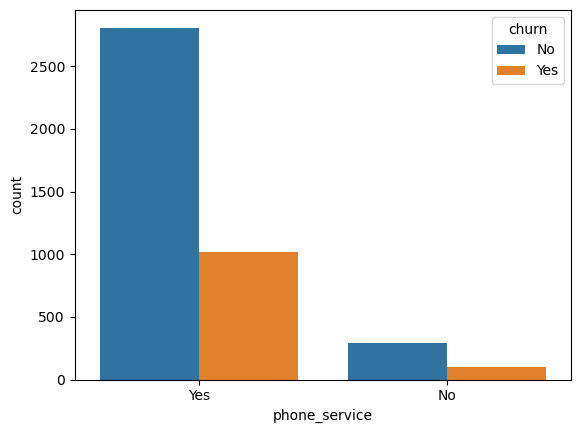

In [37]:
sns.countplot(data = train, x= train.phone_service, hue= train.churn)
#from the plot, the proportion between churn and not churn does not seem so different if customer has phone

### Analyze (with stats)

In [38]:

alpha = 0.05
null_hypothesis = "churn and monthly_charges are independent"
alternative_hypothesis = "there is a relationship between monthly_charges and churn"

stat, p_value = stats.mannwhitneyu(train[train.churn == 'Yes'].monthly_charges, train[train.churn == 'No'].monthly_charges)
if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)

print("Mann-Whitney U test p-value:", p_value)

Fail to reject the null
Insufficient evidence to reject the null


### Summarize

We can conclude that there is no correlation between phone service and churn.

## q4 Hypothesis:  Doeswhether or not customers have internet service correlate with churn?

### Visualize

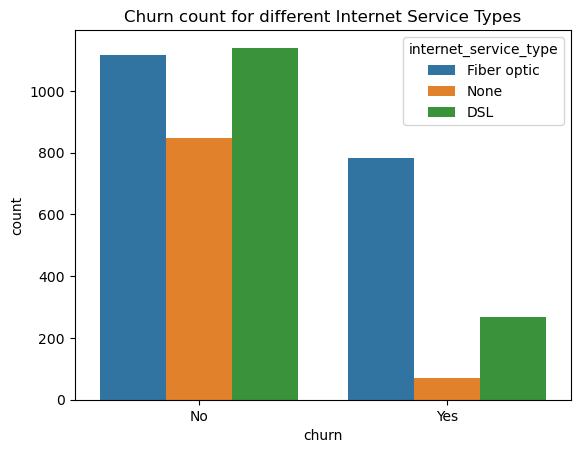

In [96]:
#plotting 

sns.countplot(train, x= train.churn, hue = train.internet_service_type);

plt.title('Churn count for different Internet Service Types')

plt.show()
#the plot would suggest that customers without internet service are much less likely to churn

### Analyze (with stats)

In [98]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "churn and internet_service_type are independent"
alternative_hypothesis = "there is a relationship between internet_service_type and churn"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn, train.internet_service_type)
chi2, p, dof, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that churn and internet_service_type are independent
Sufficient evidence to move forward understanding that there is a relationship between internet_service_type and churn


### Summarize

we can conclude that there is a correlation between internet service type and churn

# Model

# Create a baseline and briefly explain how it was calculated

In [132]:
#finding mode to determine mask for baseline accuracy
telco_prepped.churn.mode()

0    No
Name: churn, dtype: object

In [130]:
#Baseline Accuracy for comparing models
(telco_prepped.churn=='No').mean()

0.7346301292063041

## model A- decisiontree

In [131]:
#extract clean data using prepare module
telco_prepped = p.prep_telco(a.get_telco_data()) #fetching clean data directly from raw data
telco_encoded = p.encode_telco(telco_prepped) #encode the data into numeric columns
train, validate, test = p.splitting_data(telco_encoded, 'churned') #split data into train, val, and test

this file exists, reading csv


In [133]:
X_train, y_train = train.drop(columns='churned'), train.churned # 
X_val, y_val = validate.drop(columns='churned'), validate.churned # 
X_test, y_test = test.drop(columns='churned'), test.churned #

In [124]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)
clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)

In [125]:
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)

In [143]:
for x in range(1,14):
    
    X_validate = X_val
    y_validate = y_val
    
    #create the object
    tree = DecisionTreeClassifier(max_depth=x)
    
    #fit the object
    tree.fit(X_train, y_train) #fit only on TRAIN DATA!
    
    #calculate the accuracy for train
    acc = tree.score(X_train, y_train)
    
    #calculate the accuracy for validate
    acc_v = tree.score(X_validate, y_validate)
    
    print(f'max depth of {x}, the accuracy train = {round(acc,2)}, val = {round(acc_v,2)}')

max depth of 1, the accuracy train = 0.74, val = 0.73
max depth of 2, the accuracy train = 0.78, val = 0.79
max depth of 3, the accuracy train = 0.78, val = 0.79
max depth of 4, the accuracy train = 0.79, val = 0.78
max depth of 5, the accuracy train = 0.8, val = 0.78
max depth of 6, the accuracy train = 0.81, val = 0.78
max depth of 7, the accuracy train = 0.82, val = 0.78
max depth of 8, the accuracy train = 0.83, val = 0.78
max depth of 9, the accuracy train = 0.85, val = 0.78
max depth of 10, the accuracy train = 0.88, val = 0.77
max depth of 11, the accuracy train = 0.9, val = 0.76
max depth of 12, the accuracy train = 0.92, val = 0.75
max depth of 13, the accuracy train = 0.94, val = 0.74


many models overfit, the max depth of 3 performs best

## model B- 

# Deliver